We begin by importing all necessary dependencies for our analysis and setting parameters, followed by importing our pollination data.

The `poll.percent` column is a little bit strange here since a value of 0 indicates the trees were untreated (i.e., were in the control group), whereas a nonzero value of `p%` means that `n%` of flowers were hand-pollinated and the rest were pruned, leaving us with a tree having exactly `total.flowers * n%` pollinated flowers. Hence, we separate our data into artificial pollination data `artificial_pol_data` and natural pollination data `natural_pol_data`.

We then further separate each data set into data for the wet season and dry season, to obtain four data sets for analysis

In [6]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style = 'white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

#matplotlib.rcParams["figure.dpi"] = 500
matplotlib.rcParams['savefig.dpi'] = 500

pol_data = pd.read_csv("Pol_LimPodFlwr.csv").dropna()

artificial_pol_data = pol_data[pol_data['poll.percent'] != 0]
natural_pol_data = pol_data[pol_data['poll.percent'] == 0]

artificial_wet_data = artificial_pol_data[artificial_pol_data['season'] == 'wet']
artificial_dry_data = artificial_pol_data[artificial_pol_data['season'] == 'dry']
natural_wet_data = natural_pol_data[natural_pol_data['season'] == 'wet']
natural_dry_data = natural_pol_data[natural_pol_data['season'] == 'dry']

pol_data

season  plot  tree canopy.light  shading veg.proxy  poll.percent   
0      wet     1     1          nsh        0      cplx             0  \
1      wet     1     2          nsh        0      cplx             0   
2      wet     1     3          nsh        0      cplx             0   
3      wet     1     4          nsh        0      cplx             0   
4      wet     1     5          nsh        0      cplx             0   
..     ...   ...   ...          ...      ...       ...           ...   
571    dry     8     2           sh        1      cplx           100   
572    dry     8     3           sh        1      cplx           100   
573    dry     8     4           sh        1      cplx           100   
574    dry     8     5           sh        1      cplx           100   
575    dry     8     6           sh        1      cplx           100   

     total_pod.no  total.flowers  pod_prop_flwr  
0             4.0             78           5.13  
1             1.0            234           0.43  
2             2.0             37           5.41  
3             2.0            261           0.77  
4             0.0            193           0.00  
..            ...            ...            ...  
571           6.0             41          14.63  
572           2.0            106           1.89  
573           4.0             14          28.57  
574           0.0             96           0.00  
575           1.0             39           2.56  

[574 rows x 10 columns]

We begin by plotting the total yield of cocoa pods against the percentage of pollinated flowers; as we can see, we get a wide spread of values, which is expected since the total number of flowers is also varied:

<AxesSubplot: xlabel='poll.percent', ylabel='total_pod.no'>

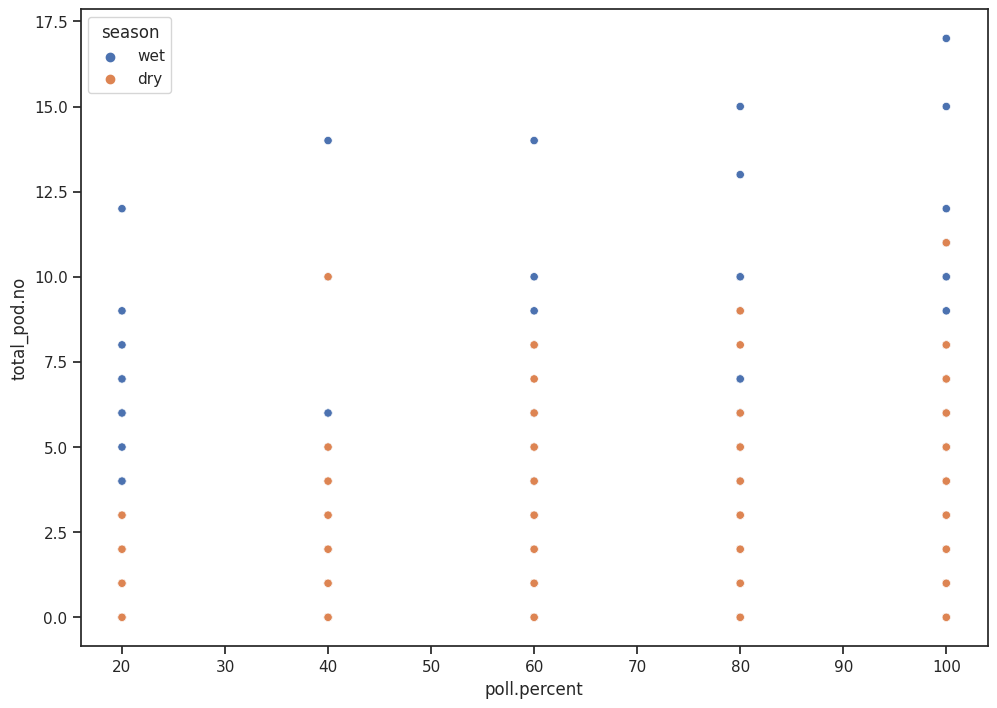

In [7]:
sns.scatterplot(
    x = "poll.percent",
    y = "total_pod.no",
    hue = "season",
    data = artificial_pol_data
)

We calculate the average open pollination yield:

In [8]:
wet_open_yield = natural_wet_data['total_pod.no'].mean()
dry_open_yield = natural_dry_data['total_pod.no'].mean()

print(f"Wet season open yield: {wet_open_yield} pods")
print(f"Dry season open yield: {dry_open_yield} pods")

Wet season open yield: 2.1666666666666665 pods
Dry season open yield: 0.0 pods


Dividing the data into buckets, we calculate, for each level of artificial pollination (20%, 40%, 60%, 80%, 100%), the average yield

In [9]:
wet_average_pol_data = pd.DataFrame(
    columns = ["poll.percent", "average total pods"],
    data = [
        (p, artificial_wet_data[artificial_wet_data['poll.percent'] == p]['total_pod.no'].mean())
        for p in [20, 40, 60, 80, 100]
    ]
)
dry_average_pol_data = pd.DataFrame(
    columns = ["poll.percent", "average total pods"],
    data = [
        (p, artificial_dry_data[artificial_dry_data['poll.percent'] == p]['total_pod.no'].mean())
        for p in [20, 40, 60, 80, 100]
    ]
)

For each case, we can do a linear regression with a zero intercept (under the assumption that 0% pollination ensures a yield of 0 pods). We may also use this to estimate the level of open pollination by using our measurements of open pollination yield and our linear regression model (since a certain level of pollination should correspond to the observed open pollination yield).

56.30252100840336
100.0


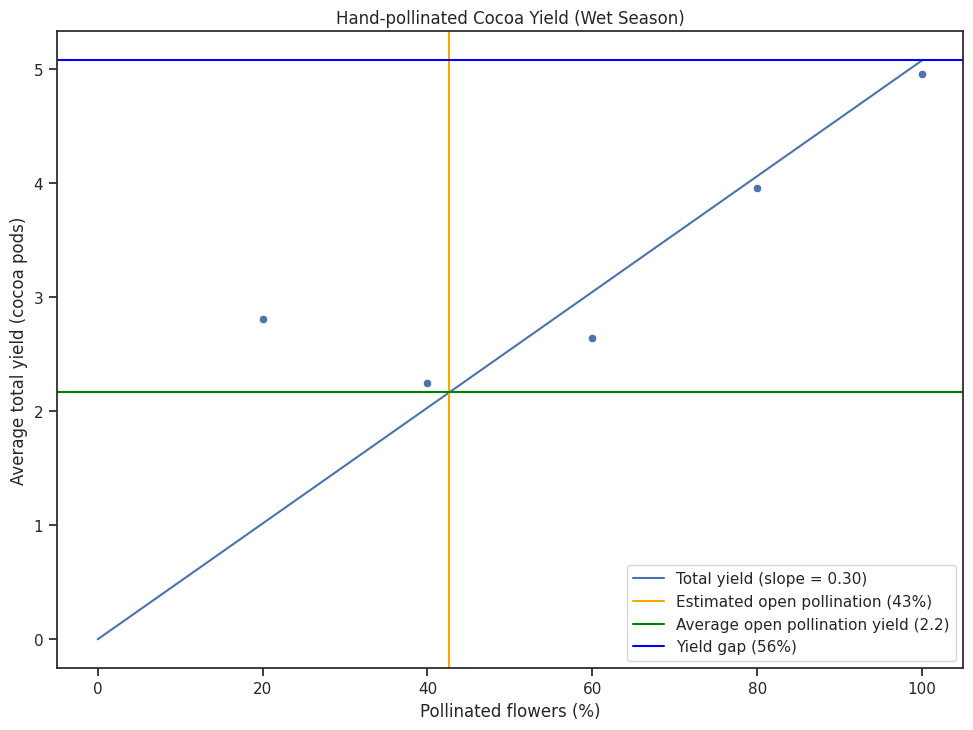

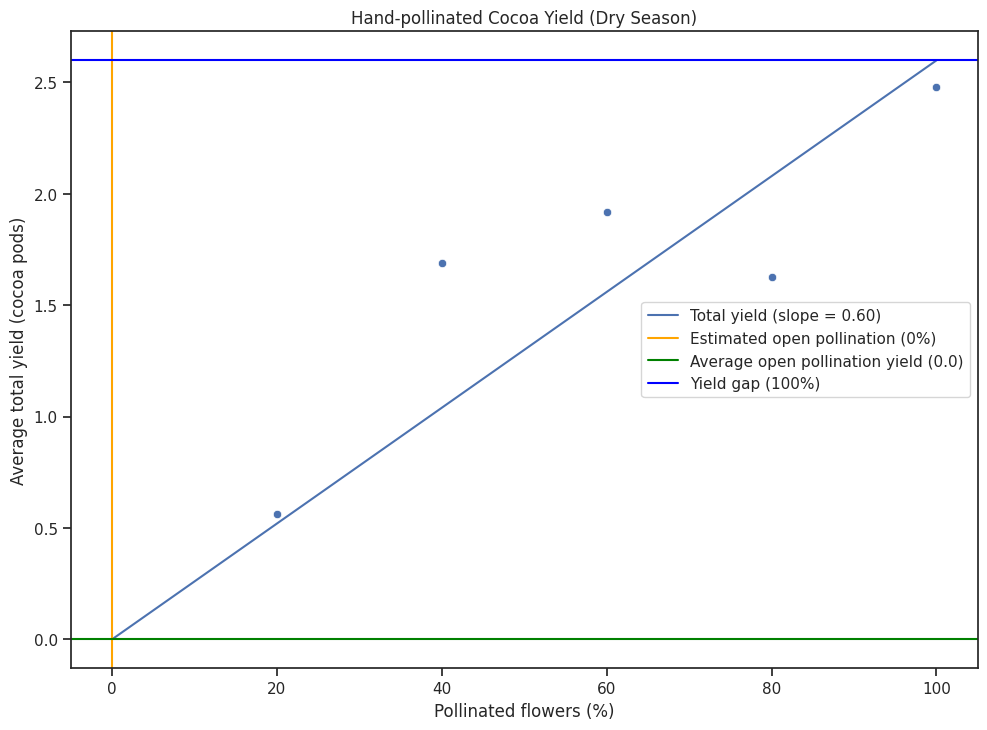

In [11]:
def calculate_statistics(x, y, open_pollination_average_yield):
    x = np.array(x)
    y = np.array(y)
    slope, residuals, _, _ = np.linalg.lstsq(x.reshape((-1, 1)), y, rcond=-1)
    mean = y.mean()
    total_sum_of_squares = sum((y - mean)**2)
    r2 = 1 - residuals/total_sum_of_squares
    open_pol = open_pollination_average_yield / slope
    yield_gap = 100 * ((y[-1] - open_pollination_average_yield) / y[-1])
    print(yield_gap)
    return slope, r2, open_pol, yield_gap

wet_slope, wet_r2, wet_open_pol, wet_yield_gap = calculate_statistics(wet_average_pol_data['poll.percent'], wet_average_pol_data['average total pods'], wet_open_yield)
dry_slope, dry_r2, dry_open_pol, dry_yield_gap = calculate_statistics(dry_average_pol_data['poll.percent'], dry_average_pol_data['average total pods'], dry_open_yield)

ax = sns.scatterplot(
    x = "poll.percent",
    y = "average total pods",
    data = wet_average_pol_data
)
ax.plot(np.array([0, 100]), np.array([0, wet_slope[0] * 100]), label = "Total yield (slope = {:0.2f})".format(wet_r2[0], wet_slope[0]))
ax.axvline(x = wet_open_pol, color = "orange", label = "Estimated open pollination ({:0.0f}%)".format(wet_open_pol[0]))
ax.axhline(y = wet_open_yield, color = "green", label = "Average open pollination yield ({:0.1f})".format(wet_open_yield))
ax.axhline(y = wet_slope * 100, color = "blue", label = "Yield gap ({:0.0f}%)".format(wet_yield_gap))
ax.legend()
ax.set(
    xlabel = "Pollinated flowers (%)",
    ylabel = "Average total yield (cocoa pods)",
    title = "Hand-pollinated Cocoa Yield (Wet Season)"
)
plt.show()

ax = sns.scatterplot(
    x = "poll.percent",
    y = "average total pods",
    data = dry_average_pol_data
)
ax.plot(np.array([0, 100]), np.array([0, dry_slope[0] * 100]), label = "Total yield (slope = {:0.2f})".format(dry_r2[0], dry_slope[0]))
ax.axvline(x = dry_open_pol, color = "orange", label = "Estimated open pollination ({:0.0f}%)".format(dry_open_pol[0]))
ax.axhline(y = dry_open_yield, color = "green", label = "Average open pollination yield ({:0.1f})".format(dry_open_yield))
ax.axhline(y = dry_slope * 100, color = "blue", label = "Yield gap ({:0.0f}%)".format(dry_yield_gap))
ax.legend()
ax.set(
    xlabel = "Pollinated flowers (%)",
    ylabel = "Average total yield (cocoa pods)",
    title = "Hand-pollinated Cocoa Yield (Dry Season)"
)
plt.show()